# CLTV Prediction

The dataset named Online Retail II includes online sales transactions of a UK-based retail company between 01/12/2009 and 09/12/2011. The company's product catalog includes souvenirs and it is known that most of its customers are wholesalers.


1. **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
2. **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. **Description**: Product (item) name. Nominal.
4. **Quantity**: The quantities of each product (item) per transaction. Numeric.
5. **InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated.
6. **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
7. **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. **Country**: Country name. Nominal. The name of the country where a customer resides.



Dataset link
https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

In [1]:
!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

     -------------------------------------- 584.2/584.2 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 48.9/48.9 kB 2.6 MB/s eta 0:00:00


In [2]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


In [4]:
df.shape

(525461, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [9]:
df.isnull().sum().sort_values(ascending=False)

Customer ID    107927
Description      2928
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

Those whose customer ID is missing should be dropped. Because we make calculations specific to the customer, it is meaningless to calculate for a customer without an ID.

In [10]:
df.dropna(inplace=True)

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0000,12.7588,101.2204,-9360.0000,2.0000,4.0000,12.0000,19152.0000
Price,417534.0000,3.8875,71.1318,0.0000,1.2500,1.9500,3.7500,25111.0900
Customer ID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


In [15]:
df = df[~df["Invoice"].str.contains("C", na=False)]

In [18]:
df = df[df["Price"] > 0]

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,13.5856,96.8407,1.0000,2.0000,5.0000,12.0000,19152.0000
Price,407664.0000,3.2944,34.7580,0.0010,1.2500,1.9500,3.7500,10953.5000
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


**Those starting with C in the Invoice variable represent returns. When the returns were removed from the dataset, the negative values we saw in the describe were gone.**

Looking at the variables of Quantity and price, the difference between 75% and max values is huge. It has outlier values. I prefer to suppress them rather than drop them

In [12]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [13]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [20]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

**Since the price is the unit price in the invoice, the total price is found by multiplying the quantity with the price.**

In [21]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [22]:
df["InvoiceDate"].max()

Timestamp('2010-12-09 20:01:00')

In [23]:
today_date = dt.datetime(2010, 12, 11)

The dataset is an old set, so today_date was created to analyze by adding 2 days to the max date.

## Preparation of Lifetime Data Structure

In [27]:
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                                         'Invoice': lambda Invoice: Invoice.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [28]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000          196        361       11   372.8600
12347.0000           37         40        2  1323.3200
12348.0000            0         74        1   222.1600
12349.0000          181        225        3  2295.0200
12351.0000            0         11        1   300.9300

In [29]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [30]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0000,196,361,11,372.8600
12347.0000,37,40,2,1323.3200
12348.0000,0,74,1,222.1600
12349.0000,181,225,3,2295.0200
12351.0000,0,11,1,300.9300


In [31]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

Monetary is divided by frequency because it is the average, not the total amount. Monetry in the RFM analysis was the total value, while in the CLTV it was the average value.

In [32]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [33]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,196,361,11,33.8964
12347.0000,37,40,2,661.6600
12348.0000,0,74,1,222.1600
12349.0000,181,225,3,765.0067
12351.0000,0,11,1,300.9300


In [34]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4312.0000,133.9986,132.8272,0.0000,0.0000,105.0000,254.0000,373.0000
T,4312.0000,225.4970,118.9098,1.0000,117.0000,253.0000,329.0000,374.0000
frequency,4312.0000,4.4557,8.1702,1.0000,1.0000,2.0000,5.0000,205.0000
monetary,4312.0000,358.6432,347.7206,2.9500,178.4787,283.1710,418.8906,5633.4650


Frequency must be greater than 1. Customers who shop at least 2 times are counted

In [35]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [36]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7
#Converted weekly by dividing by 7

## Establishment of BG-NBD Model

In [37]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 0.14, alpha: 10.85, b: 2.72, r: 2.13>

Who are the 10 customers we expect the most to purchase in 1 week?

In [38]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)


Customer ID
14911.0000   3.2155
17850.0000   2.4259
12748.0000   2.2820
15311.0000   1.9107
13089.0000   1.7232
14606.0000   1.6210
14156.0000   1.6040
13694.0000   1.4845
17841.0000   1.4478
18102.0000   1.4136
dtype: float64

In [40]:
cltv_df["expected_purc_1_week"] = bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                                                          cltv_df['frequency'],
                                                                                          cltv_df['recency'],
                                                                                          cltv_df['T'])
#1-week sales forecast for all customers

In [41]:
cltv_df["expected_purc_3_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4 * 3,
                                                                                           cltv_df['frequency'],
                                                                                           cltv_df['recency'],
                                                                                           cltv_df['T'])
#3-months sales forecast for all customers

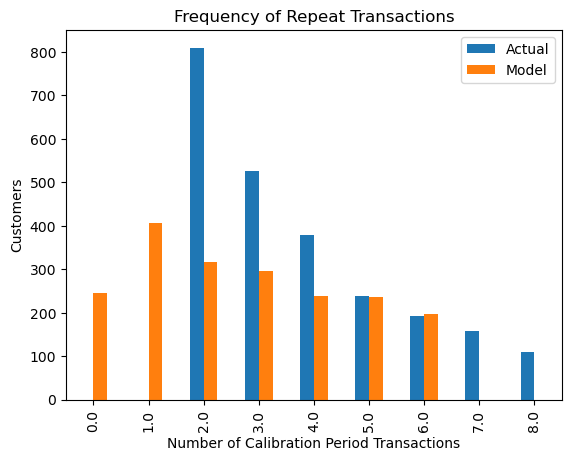

In [43]:
plot_period_transactions(bgf)
plt.show()

## Establishing the GAMMA-GAMMA Model

In [44]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 3.79, q: 0.34, v: 3.73>

In [45]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12357.0000   6172.3459
17450.0000   5457.7883
14091.0000   5022.9216
14088.0000   4792.1915
18102.0000   3533.3926
12409.0000   3228.0113
14646.0000   3115.7658
12454.0000   2940.2847
16684.0000   2866.3781
12415.0000   2851.5073
dtype: float64

In [46]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])

In [48]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(15)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,
12357.0000,0.0000,3.4286,2,5633.4650,0.2573,2.9534,6172.3459
17450.0000,10.0000,10.5714,7,5321.5850,0.4162,4.8410,5457.7883
14091.0000,6.2857,47.7143,2,4584.0450,0.0099,0.1167,5022.9216
14088.0000,2.0000,8.1429,3,4512.9900,0.2199,2.5478,4792.1915
18102.0000,53.2857,53.4286,89,3526.4424,1.4136,16.7696,3533.3926
12409.0000,20.5714,28.7143,4,3086.6550,0.1404,1.6535,3228.0113
14646.0000,51.7143,53.2857,78,3108.7672,1.2320,14.6155,3115.7658
12454.0000,3.5714,8.1429,4,2811.4450,0.2835,3.2849,2940.2847
16684.0000,50.2857,52.5714,27,2847.7670,0.4523,5.3648,2866.3781


## Calculation of CLTV with BG-NBD and GG model

In [49]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 months
                                   freq="W", 
                                   discount_rate=0.01)

In [51]:
cltv.head(15)

Customer ID
12346.0000      13.8130
12347.0000    2120.5530
12349.0000    1138.6045
12352.0000     604.6512
12356.0000    3869.2110
12357.0000   19350.4200
12358.0000     946.4724
12359.0000     660.4627
12360.0000     541.8668
12361.0000     116.6623
12369.0000     753.1412
12370.0000      26.1611
12371.0000     908.5143
12373.0000      77.9859
12374.0000    1087.0940
Name: clv, dtype: float64

In [52]:
cltv = cltv.reset_index()

In [53]:
cltv.head()

,Customer ID,clv
0,12346.0000,13.8130
1,12347.0000,2120.5530
2,12349.0000,1138.6045
3,12352.0000,604.6512
4,12356.0000,3869.2110


In [54]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [55]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_month,expected_average_profit,clv
2827,18102.0000,53.2857,53.4286,89,3526.4424,1.4136,16.7696,3533.3926,63037.4868
1096,14646.0000,51.7143,53.2857,78,3108.7672,1.2320,14.6155,3115.7658,48446.5167
846,14156.0000,52.2857,53.4286,102,1791.7474,1.6040,19.0293,1794.8458,36335.9152
1229,14911.0000,53.2857,53.4286,205,698.9298,3.2155,38.1474,699.5418,28389.9651
2499,17450.0000,10.0000,10.5714,7,5321.5850,0.4162,4.8410,5457.7883,28068.6218
616,13694.0000,51.5714,53.0000,94,1364.9177,1.4845,17.6104,1367.4888,25619.7519
5,12357.0000,0.0000,3.4286,2,5633.4650,0.2573,2.9534,6172.3459,19350.4200
2523,17511.0000,52.7143,53.2857,31,2726.2206,0.5130,6.0860,2741.7306,17751.5867
2099,16684.0000,50.2857,52.5714,27,2847.7670,0.4523,5.3648,2866.3781,16359.4486
1300,15061.0000,53.0000,53.4286,86,938.1211,1.3657,16.2012,940.0665,16202.8775


In [58]:
#Segmentation
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(20)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_month,expected_average_profit,clv,segment
2827,18102.0000,53.2857,53.4286,89,3526.4424,1.4136,16.7696,3533.3926,63037.4868,A
1096,14646.0000,51.7143,53.2857,78,3108.7672,1.2320,14.6155,3115.7658,48446.5167,A
846,14156.0000,52.2857,53.4286,102,1791.7474,1.6040,19.0293,1794.8458,36335.9152,A
1229,14911.0000,53.2857,53.4286,205,698.9298,3.2155,38.1474,699.5418,28389.9651,A
2499,17450.0000,10.0000,10.5714,7,5321.5850,0.4162,4.8410,5457.7883,28068.6218,A
616,13694.0000,51.5714,53.0000,94,1364.9177,1.4845,17.6104,1367.4888,25619.7519,A
5,12357.0000,0.0000,3.4286,2,5633.4650,0.2573,2.9534,6172.3459,19350.4200,A
2523,17511.0000,52.7143,53.2857,31,2726.2206,0.5130,6.0860,2741.7306,17751.5867,A
2099,16684.0000,50.2857,52.5714,27,2847.7670,0.4523,5.3648,2866.3781,16359.4486,A
1300,15061.0000,53.0000,53.4286,86,938.1211,1.3657,16.2012,940.0665,16202.8775,A


In [59]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                     recency                        T                  frequency             monetary                   expected_purc_1_week                expected_purc_3_month                 expected_average_profit                         clv                   
               mean count           sum    mean count        sum    mean count        sum      mean count   sum     mean count         sum                 mean count      sum                  mean count       sum                    mean count         sum      mean count          sum
segment                                                                                                                                                                                                                                                                                    
D        15527.8522   724 11242165.0000 21.9943   724 15923.8571 41.0529   724 29722.2857    3.2486   724  2352 199.9623   724 144772.7395               0.0653   724  47.2967                0.7711   724  558.3026                215.9256   724 156330.1066  140.3912   724  101643.1973
C        15444.6542   723 11166485.0000 30.0692   723 21740.0000 37.5527   723 27150.5714    4.2254   723  3055 267.5635   723 193448.4314               0.1219   723  88.1122                1.4365   723 1038.6014                284.8501   723 205946.6389  381.4726   723  275804.6830
B        15302.5795   723 11063765.0000 30.1237   723 21779.4286 35.4145   723 25604.7143    5.5367   723  4003 373.3217   723 269911.6088               0.1621   723 117.1893                1.9068   723 1378.5875                393.7591   723 284687.8039  677.8842   723  490110.2909
A        15128.0581   723 10937586.0000 31.9500   723 23099.8571 35.5471   723 25700.5714   11.5961   723  8384 656.1355   723 474385.9572               0.2740   723 198.1079                3.2278   723 2333.7070                682.9001   723 493736.7592 2227.3224   723 1610354.0809